In [1]:
from utils import *
np.random.seed(42)

In [2]:
# Path to subjects' data
subjects_path = "subjects"
n_subjects = len(os.listdir(subjects_path)) -1  # Get the number of subjects
print(f'There are {n_subjects} subjects.')
files = [f for f in os.listdir('subjects') if os.path.isfile(os.path.join('subjects', f))]
print(files) #there is one extra file in the directory....

There are 27 subjects.
['.DS_Store']


In [3]:
# Initialize data storage
# all_datasets = []
# all_labels = []
# subject_ids = []
combined = pd.DataFrame(np.nan, index=range(27*120), columns=['ID', 'Label'] + list(range(0, 70)))

# Define feature functions
feature_functions = [mav, rms, wl, ssc,std, mf, maxav]

# Path to subjects' data
subjects_path = "subjects"
n_subjects = len(os.listdir(subjects_path)) -1  # Get the number of subjects

# Loop through each subject
for subject_idx in range(n_subjects):
    print(f"Processing Subject {subject_idx + 1}/{n_subjects}...")

    # Load subject data
    subject_file = f"{subjects_path}/s{subject_idx + 1}/S{subject_idx + 1}_A1_E1.mat"
    data = loadmat(subject_file)
    
    # Extract data
    emg = data["emg"]
    emg_rectified = np.abs(emg)  # Rectify EMG signals
    stimulus = data["restimulus"].flatten()
    repetition = data["rerepetition"].flatten()

    # Step 1: Pre-process EMG to calculate envelopes
    emg_envelopes = emg_envelope(emg_rectified, stimulus, repetition)

    # Step 2: Calculate average activations
    emg_average_activations = compute_emg_average_activations(emg_envelopes)

    # Step 3: Identify trials to exclude
    exclude_list = trial_to_exclude_all(emg_envelopes, window_ms=2000)

    # Step 4: Build the dataset for the subject
    dataset, labels = build_dataset_from_ninapro(
        emg_envelopes,
        features=feature_functions,
        exclude_list=exclude_list
    )

    combined.iloc[subject_idx*120:(subject_idx*120+dataset.shape[0]), 0] = np.ones_like(labels)*(subject_idx+1)
    combined.iloc[subject_idx*120:(subject_idx*120+dataset.shape[0]), 1] = labels
    combined.iloc[subject_idx*120:(subject_idx*120+dataset.shape[0]), 2:] = dataset

    # Store the dataset and labels
    # all_datasets.append(dataset)
    # all_labels.append(labels)
    # subject_ids.extend([subject_idx + 1] * len(labels))  # Add the subject ID for each row

combined = combined.dropna(how='all')

# # Combine datasets and labels if desired
# combined_dataset = np.vstack(all_datasets)
# combined_labels = np.hstack(all_labels)
# final_subject_ids = np.array(subject_ids)

# print("Data processing completed for all subjects.")
# # Check the shapes
# print(f"Dataset shape: {combined_dataset.shape}")
# print(f"Labels shape: {combined_labels.shape}")
# print(f"Subject IDs shape: {final_subject_ids.shape}")

# Check the shapes
print(f"Dataset shape: {combined.shape}")
print(f"Features shape: {combined.iloc[:,2:].shape}")
print(f"Labels shape: {combined.iloc[:,1].shape}")
print(f"Subject IDs shape: {combined.iloc[:,0].shape}")

Processing Subject 1/27...
Trials to exclude for Stimulus 1: [5, 8, 9, 10]
Trials to exclude for Stimulus 2: [2, 3, 4, 9, 10]
Trials to exclude for Stimulus 3: [3, 6, 8, 9]
Trials to exclude for Stimulus 4: []
Trials to exclude for Stimulus 5: []
Trials to exclude for Stimulus 6: []
Trials to exclude for Stimulus 7: []
Trials to exclude for Stimulus 8: []
Trials to exclude for Stimulus 9: []
Trials to exclude for Stimulus 10: [1, 7, 9]
Trials to exclude for Stimulus 11: [2, 6, 9]
Trials to exclude for Stimulus 12: [2, 4, 5, 6, 8, 9, 10]
Processing Subject 2/27...
Trials to exclude for Stimulus 1: []
Trials to exclude for Stimulus 2: []
Trials to exclude for Stimulus 3: []
Trials to exclude for Stimulus 4: [10]
Trials to exclude for Stimulus 5: [1]
Trials to exclude for Stimulus 6: []
Trials to exclude for Stimulus 7: []
Trials to exclude for Stimulus 8: [1, 4]
Trials to exclude for Stimulus 9: []
Trials to exclude for Stimulus 10: []
Trials to exclude for Stimulus 11: []
Trials to excl

### Question 2
features - Are there any similarity/discrepancies between the subjects?

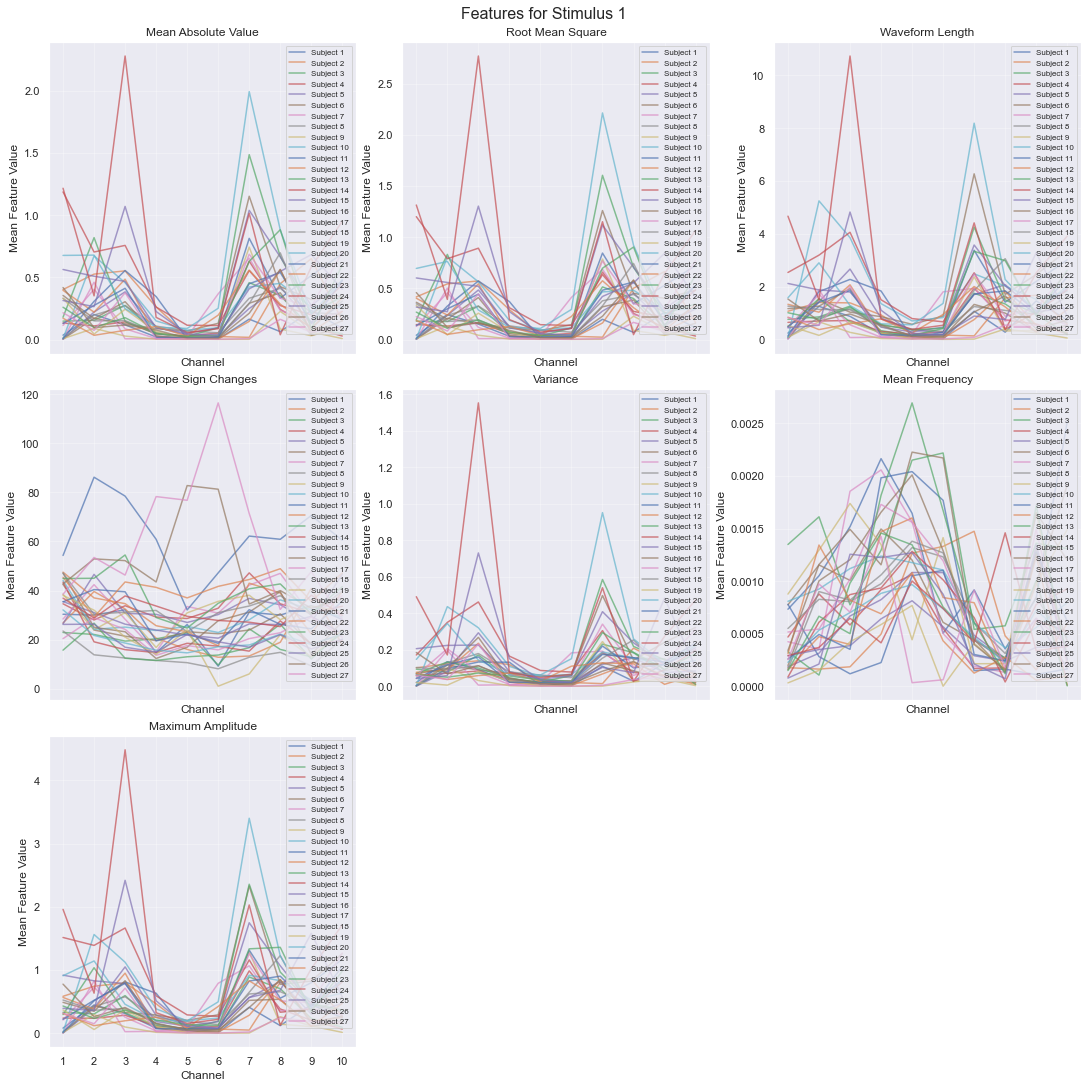

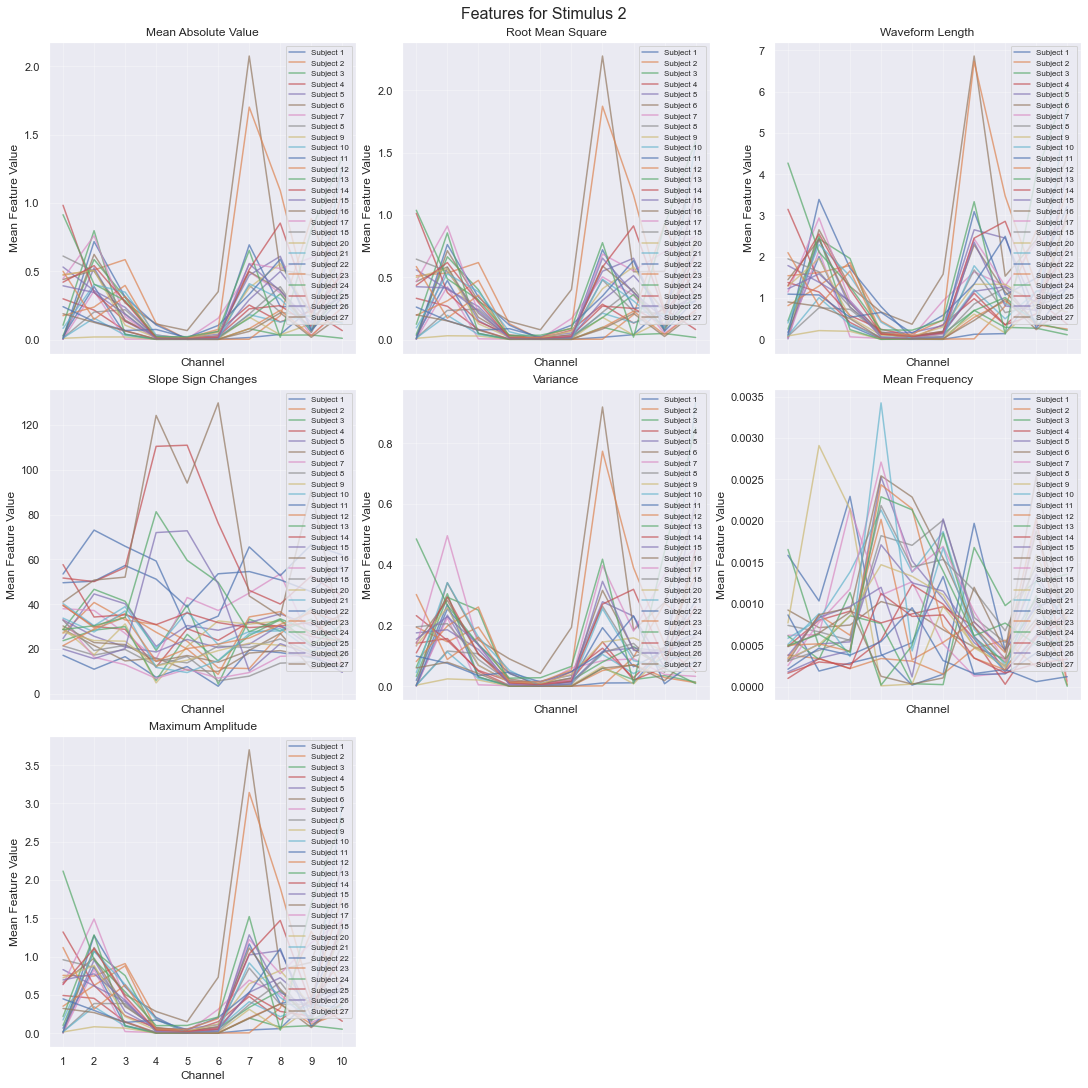

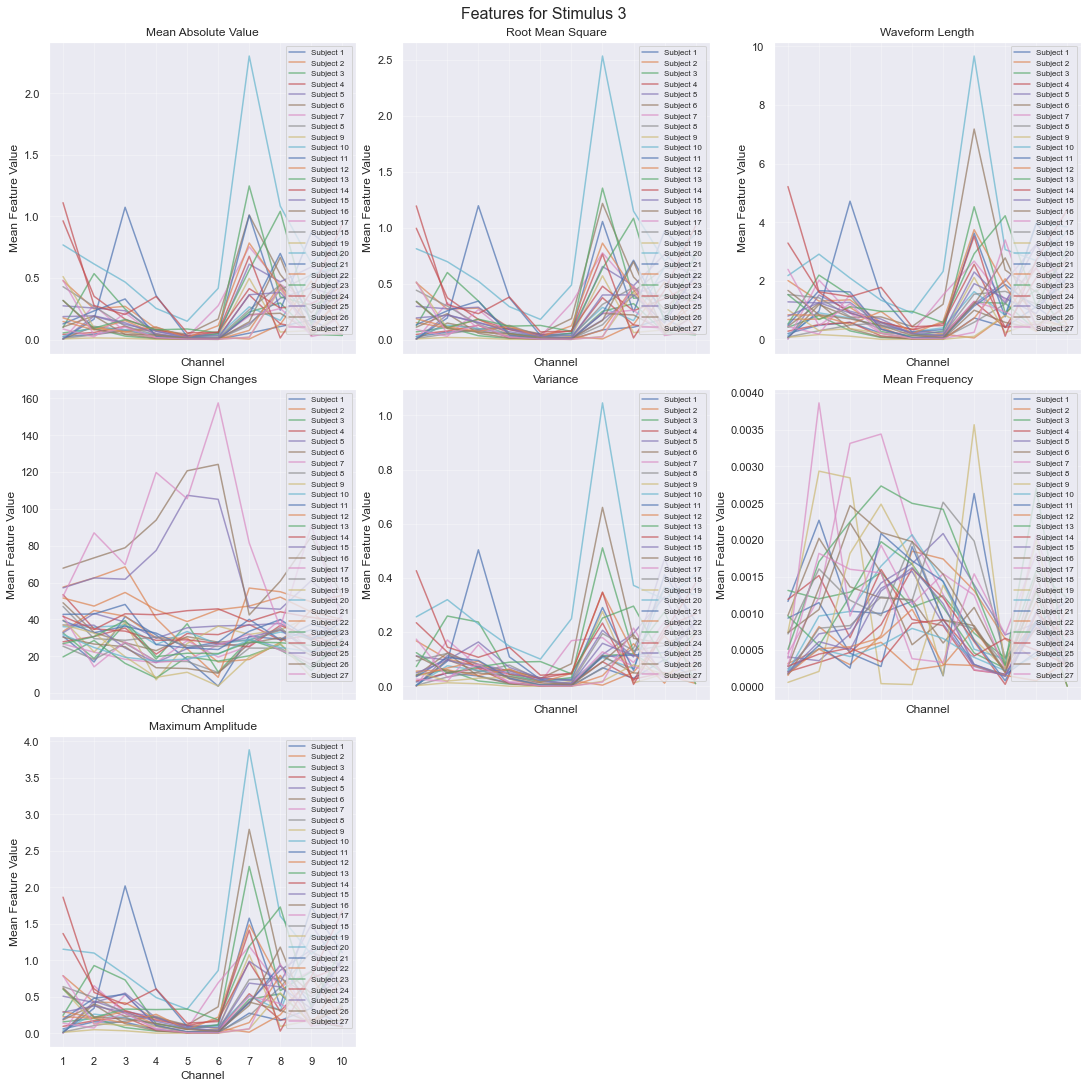

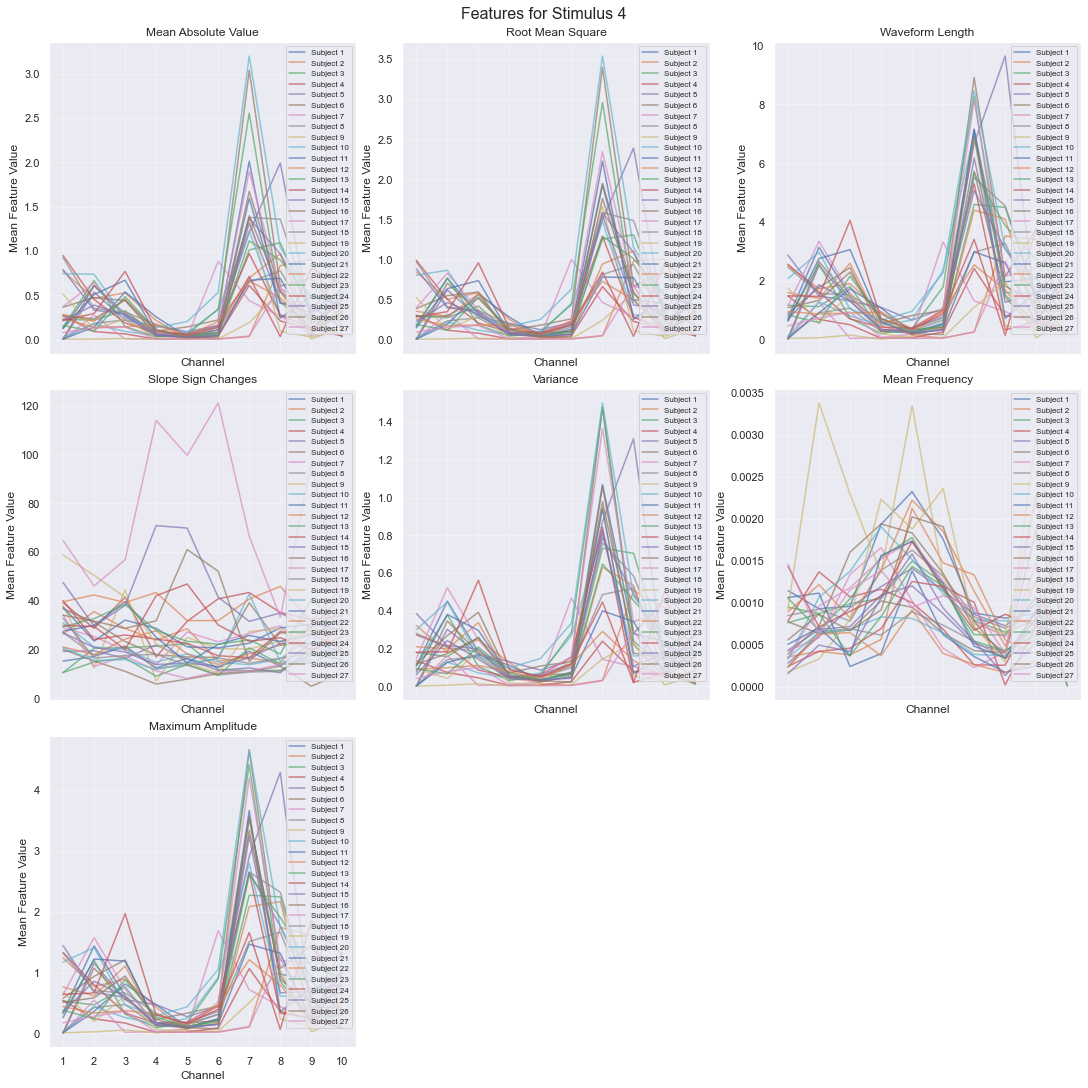

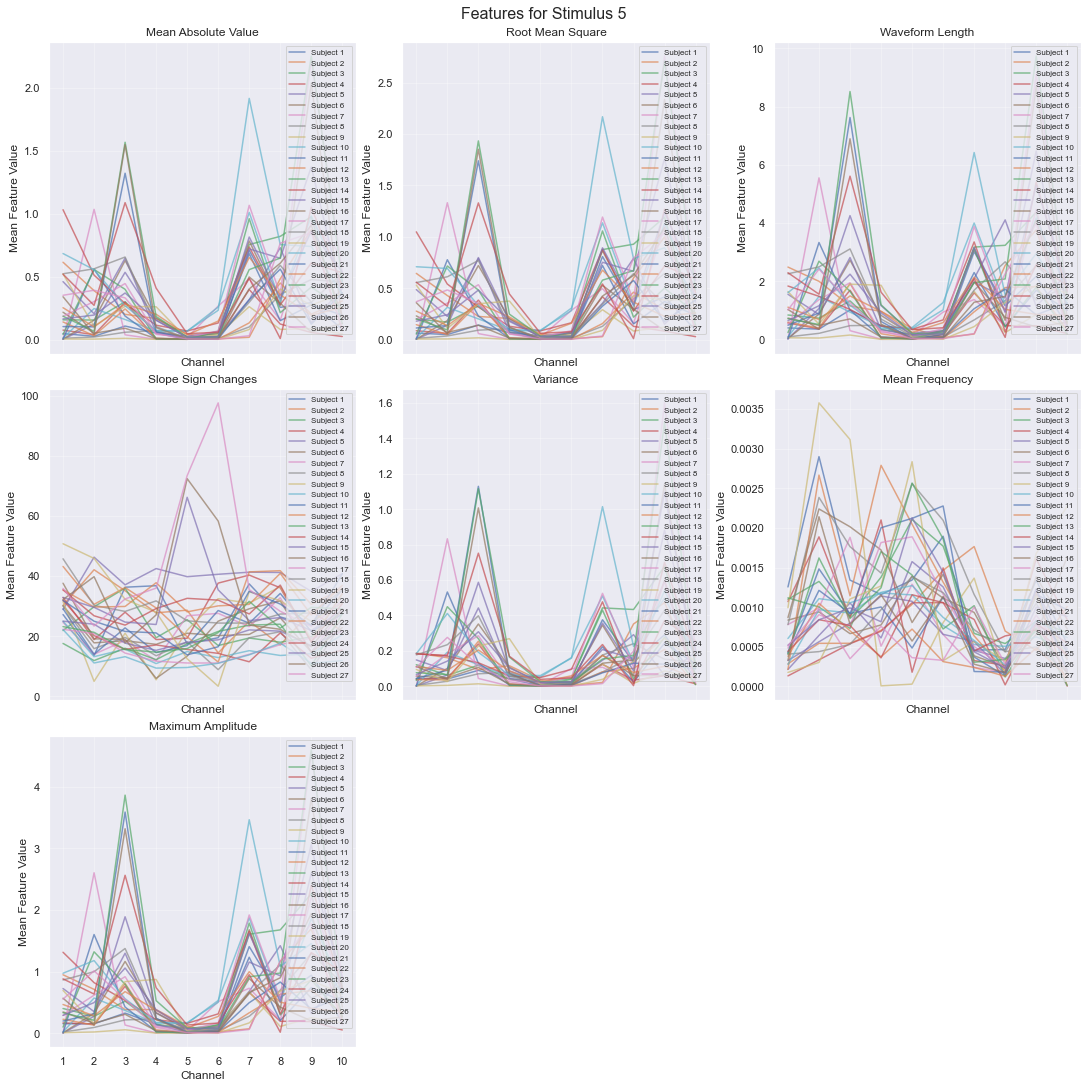

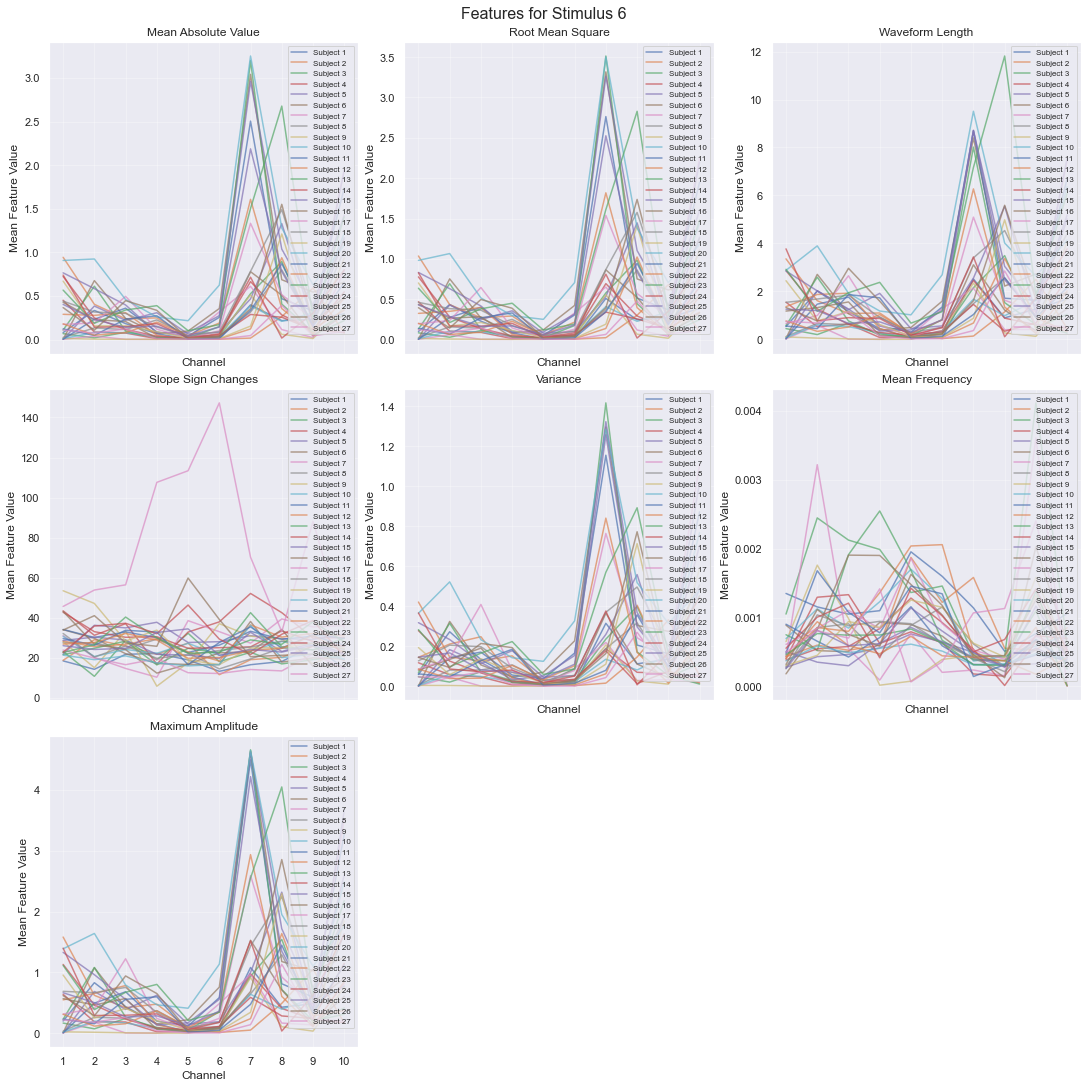

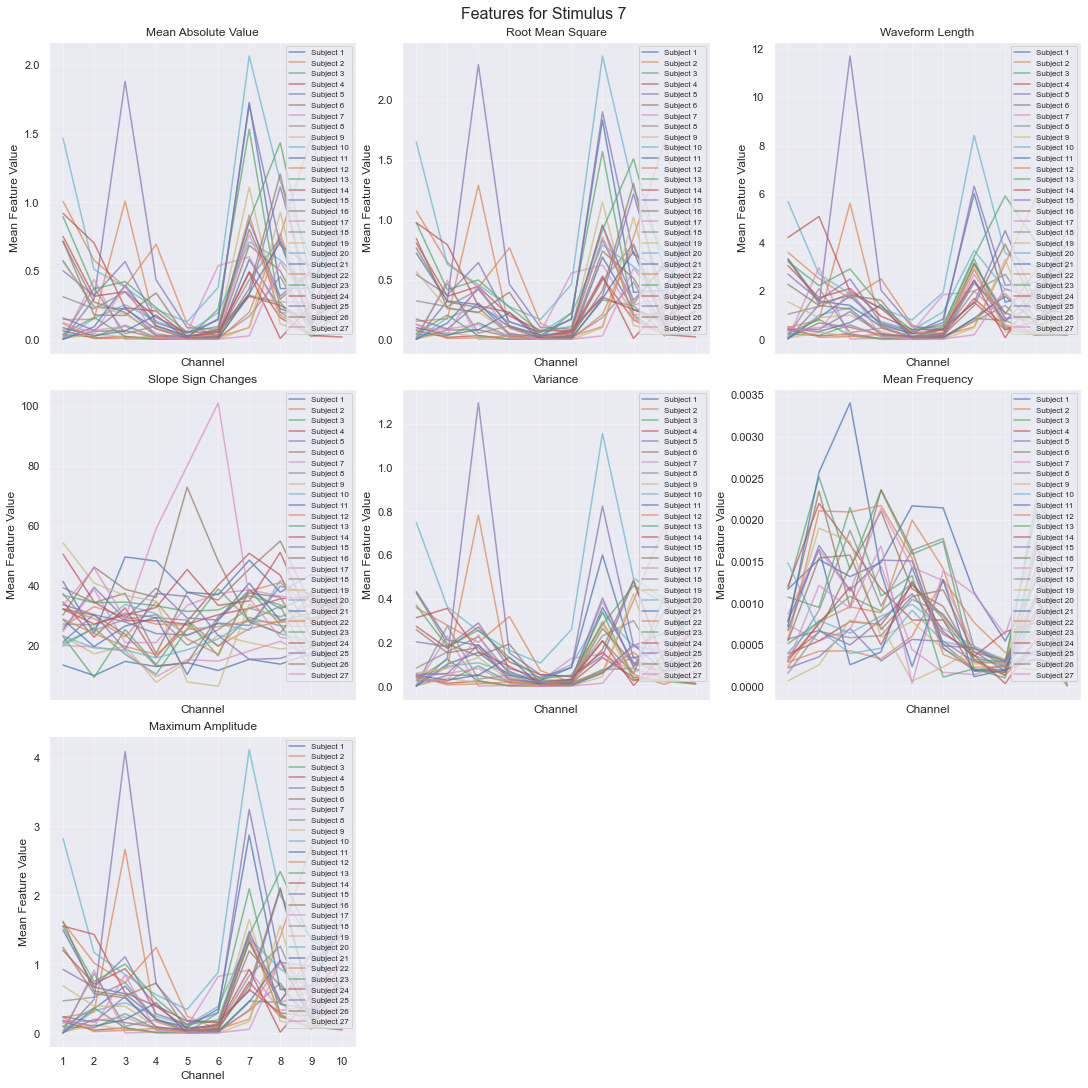

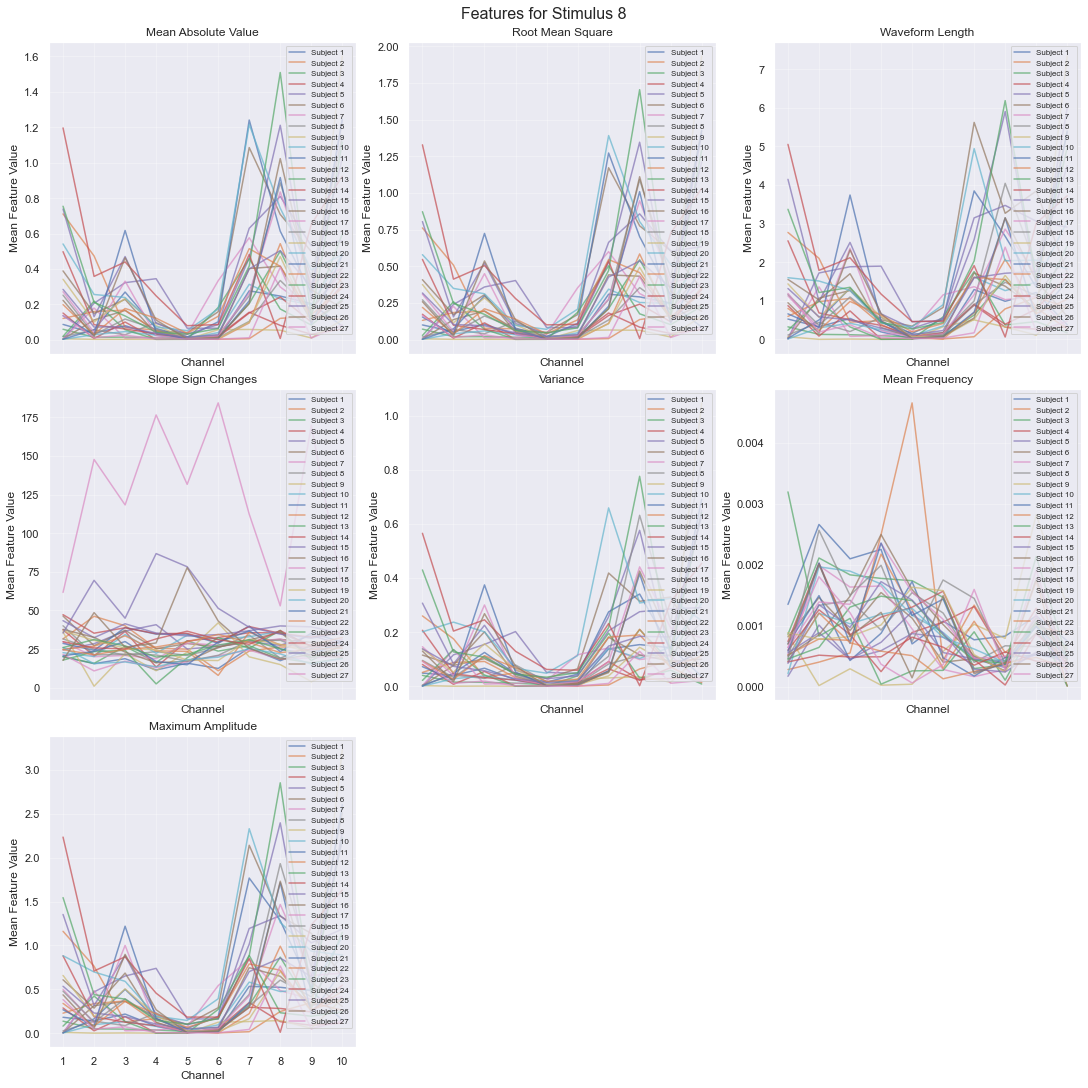

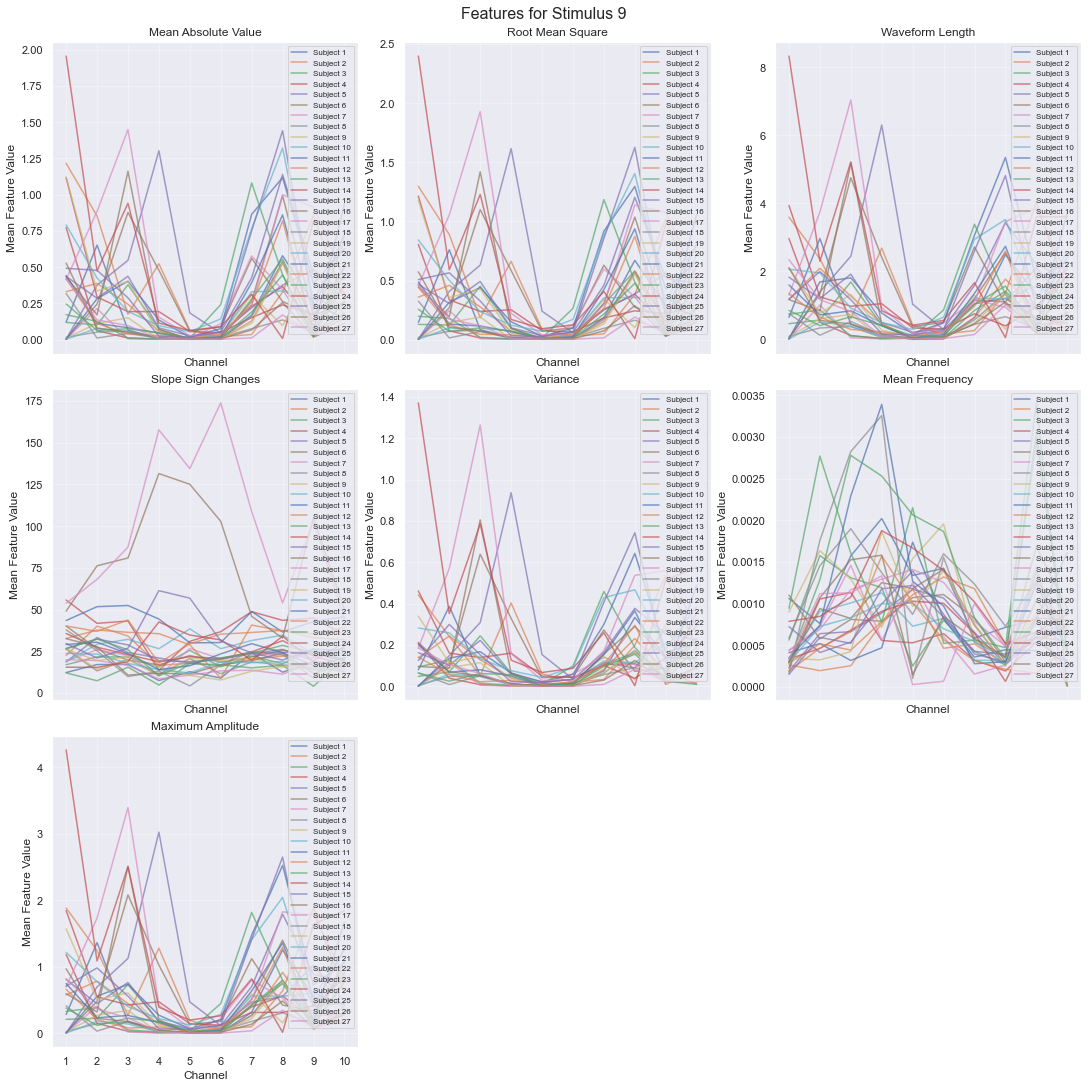

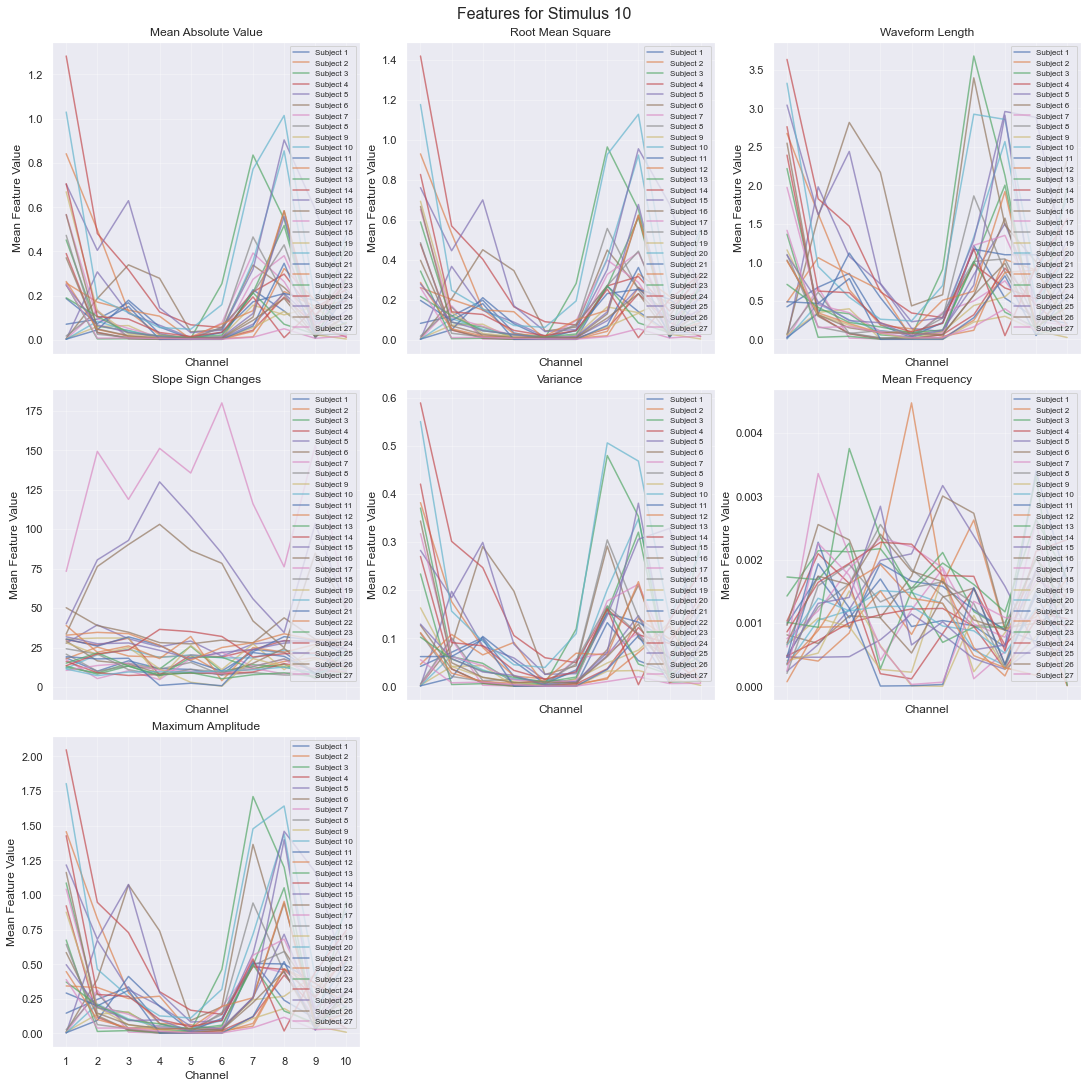

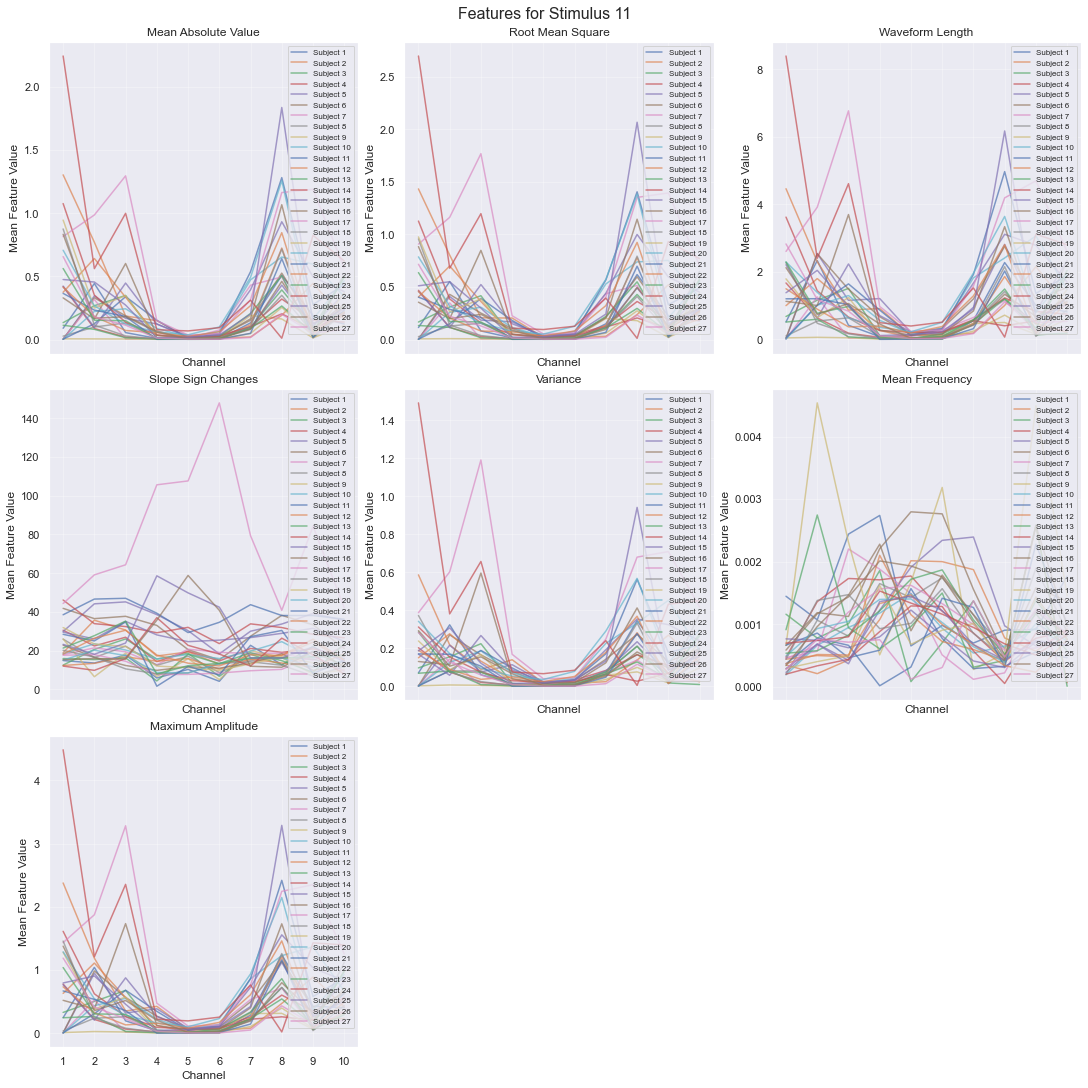

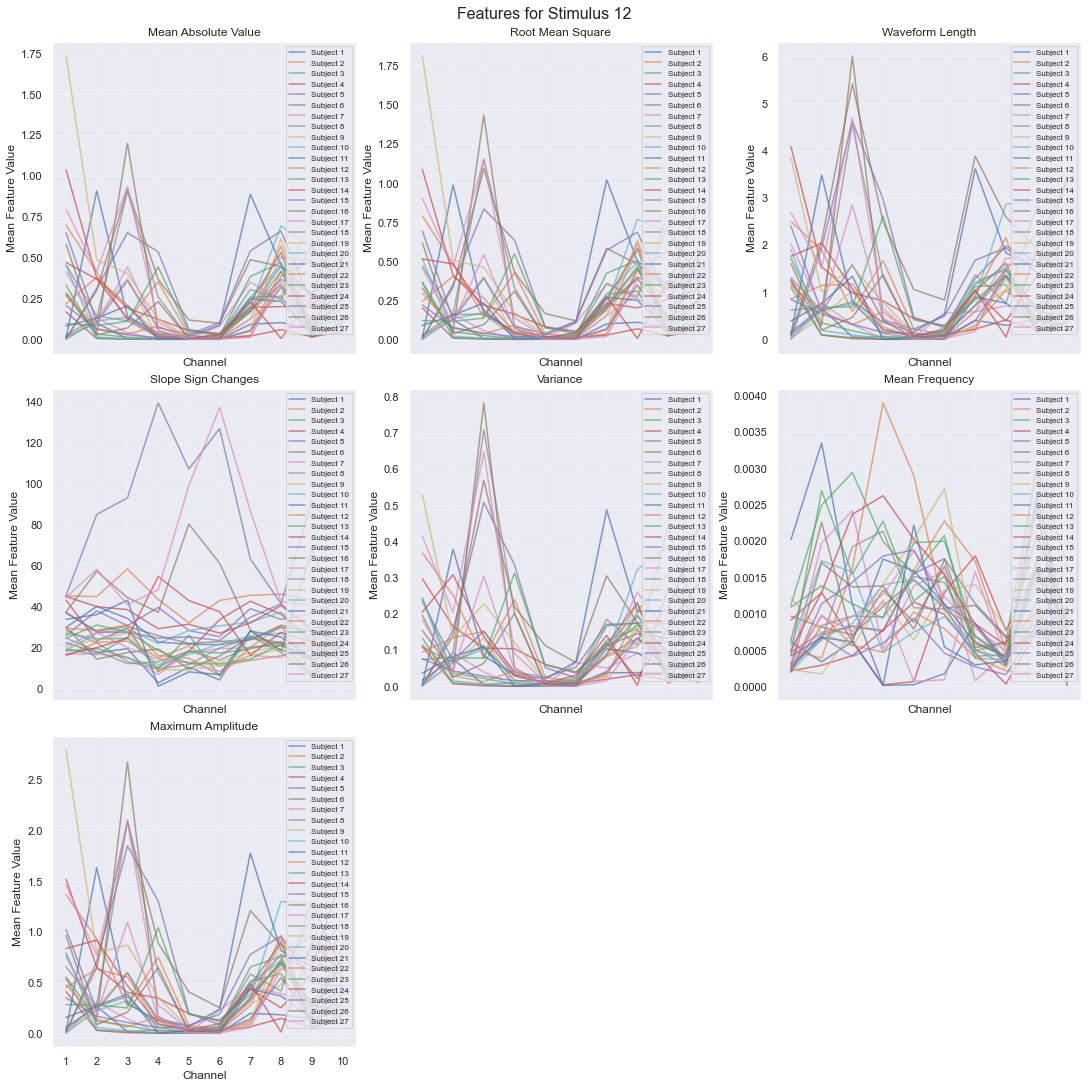

In [4]:
plot_feature_subjects(combined, n_stimuli=12, n_channels=10)

### Question 3
classification model on 26 subjects

In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
train_set = combined.copy()
test_set = combined.copy()
train_set = train_set[train_set['ID'] != 2]
test_set = test_set[test_set['ID'] == 2]

X_train = np.array(train_set.iloc[:, 2:])
y_train = np.array(train_set.iloc[:, 1])
X_test = np.array(test_set.iloc[:, 2:])
y_test = np.array(test_set.iloc[:, 1])

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test) 

Accuracy: 18.10%, F1-score: 0.14


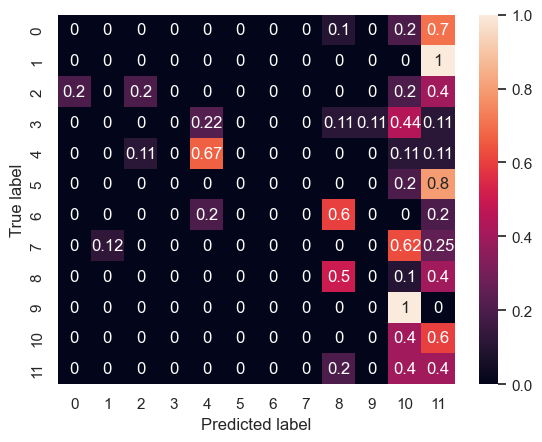

In [5]:
# best model from Part 1
bootstrap = True
n_estimators = 80
max_depth  = None
min_samples_split = 6
min_samples_leaf = 1
max_features: 'log2'

clf = RandomForestClassifier(random_state=42, 
                             bootstrap = bootstrap,
                             n_estimators = n_estimators,
                             max_depth  = max_depth,
                             min_samples_split = min_samples_split,
                             min_samples_leaf = min_samples_leaf,
                             max_features = 'log2',
                             class_weight='balanced')

clf.fit(X_train_z, y_train)
y_pred = clf.predict(X_test_z)
accuracy = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy*100:.2f}%, F1-score: {F1:.2f}')

confmat = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

### Question 4
Cross-validation

In [6]:
# Cross validation using 1 subject as test set, the other 26 subjects as validation set
test_accuracies = []
test_F1 = []
for subj in range(1,28):
    train_set = combined.copy()
    test_set = combined.copy()
    train_set = train_set[train_set['ID'] != subj]
    test_set = test_set[test_set['ID'] == subj]

    X_train = np.array(train_set.iloc[:, 2:])
    y_train = np.array(train_set.iloc[:, 1])
    X_test = np.array(test_set.iloc[:, 2:])
    y_test = np.array(test_set.iloc[:, 1])

    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
    X_test_z = scaler.transform(X_test) 

    clf = RandomForestClassifier(random_state=42, 
                                bootstrap = bootstrap,
                                n_estimators = n_estimators,
                                max_depth  = max_depth,
                                min_samples_split = min_samples_split,
                                min_samples_leaf = min_samples_leaf,
                                max_features = 'log2',
                                class_weight='balanced')

    clf.fit(X_train_z, y_train)
    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average='weighted')

    test_accuracies.append(accuracy)
    test_F1.append(F1)

print('The mean accuracy over all the trials is ', np.array(test_accuracies).mean())
print('The mean F1 score over all the trials is:', np.mean(test_F1))

The mean accuracy over all the trials is  0.36179776246114587
The mean F1 score over all the trials is: 0.31230073598294655


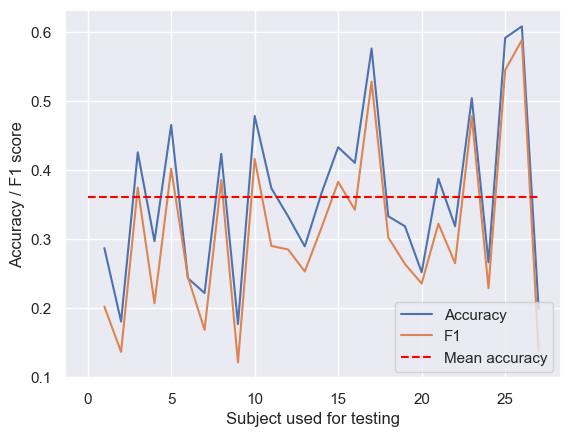

In [7]:
plt.plot(np.arange(1, 28), test_accuracies, label = 'Accuracy')
plt.plot(np.arange(1, 28), test_F1, label = 'F1')
plt.hlines(y = np.array(test_accuracies).mean(), xmin=0, xmax=27, linestyles='--', color='red', label = 'Mean accuracy')
plt.xlabel('Subject used for testing')
plt.ylabel('Accuracy / F1 score')
plt.legend(loc='lower right')
plt.show()

### Question 5
Increase the training set by subject at a time

In [10]:
subject_test = 27
test_accuracies = []
test_F1 = []

for subj in range(2,28):
    train_set = combined.copy()
    subject_train = np.arange(1, subj)
    train_set = train_set[train_set['ID'].isin(subject_train)]
    test_set = test_set[test_set['ID'] == subject_test]

    X_train = np.array(train_set.iloc[:, 2:])
    y_train = np.array(train_set.iloc[:, 1])
    X_test = np.array(test_set.iloc[:, 2:])
    y_test = np.array(test_set.iloc[:, 1])

    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
    X_test_z = scaler.transform(X_test) 

    clf = RandomForestClassifier(random_state=42, 
                             bootstrap = bootstrap,
                             n_estimators = n_estimators,
                             max_depth  = max_depth,
                             min_samples_split = min_samples_split,
                             min_samples_leaf = min_samples_leaf,
                             max_features = 'log2',
                             class_weight='balanced')

    clf.fit(X_train_z, y_train)
    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average='weighted')

    test_accuracies.append(accuracy)
    test_F1.append(F1)

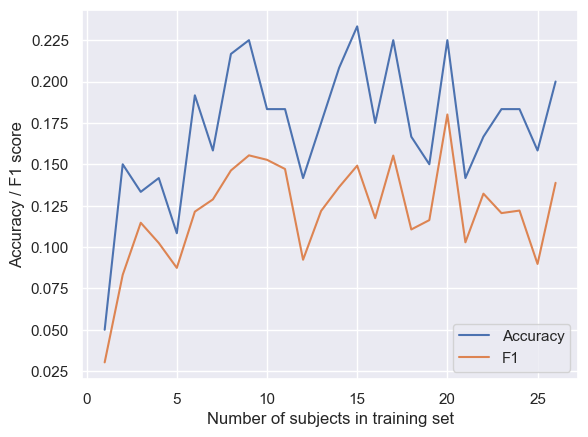

In [11]:
plt.plot(np.arange(1, 27), test_accuracies, label = 'Accuracy')
plt.plot(np.arange(1, 27), test_F1, label = 'F1')
plt.xlabel('Number of subjects in training set')
plt.ylabel('Accuracy / F1 score')
plt.legend(loc='lower right')
plt.show()

/var/folders/kq/nzqfm4f10nj5cc_vvc_tzdnh0000gn/T/ipykernel_35747/2354281114.py:5: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c) + d


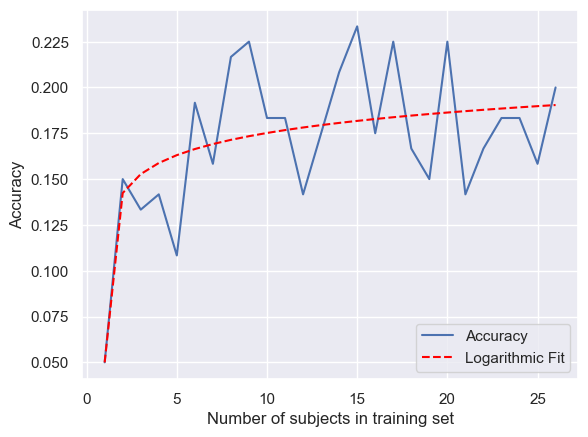

In [12]:
from scipy.optimize import curve_fit

# Define a logarithmic function for the fit
def log_func(x, a, b, c, d):
    return a * np.log(b * x + c) + d

subjects = np.arange(1, 27) 

# Fit the data to the logarithmic function
params, covariance = curve_fit(log_func, subjects, test_accuracies, maxfev=10000)

# Extract the fitted parameters
a, b, c, d = params

# Generate the fitted curve using the parameters
fitted_curve_acc = log_func(subjects, a, b, c, d)

# # Fit the data to the logarithmic function
# params, covariance = curve_fit(log_func, subjects, test_F1, maxfev=10000)

# # Extract the fitted parameters
# a, b, c, d = params

# # Generate the fitted curve using the parameters
# fitted_curve_F1 = log_func(subjects, a, b, c, d)

# Plot the original accuracies and the logarithmic fit
plt.plot(subjects, test_accuracies, label='Accuracy')
# plt.plot(subjects, test_F1, label = 'F1')
plt.plot(subjects, fitted_curve_acc, label='Logarithmic Fit', linestyle='--', color='red')
# plt.plot(subjects, fitted_curve_F1, label='Logarithmic Fit', linestyle='-.', color='red')
plt.xlabel('Number of subjects in training set')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()